In [1]:
import rasterio
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
from sarpy.visualization.remap import density
import pandas as pd
import glob
import os
import tensorflow as tf
from tensorflow.keras.utils import Progbar
from PIL import Image

from PIL import Image
from sarpy.visualization.remap import density
import gc
from patchify import patchify

## caesar-radi dataset

In [3]:
img_files_vv = glob.glob('/tf/media/ryan/SATA1/datasets/xview3/pretrain/caesar-radi/SAR-Ship-Dataset/ship_dataset_v0/Gao*hh*.jpg')
img_files_vh = glob.glob('/tf/media/ryan/SATA1/datasets/xview3/pretrain/caesar-radi/SAR-Ship-Dataset/ship_dataset_v0/Gao*hv*.jpg')
# annotation_files = glob.glob('/tf/media/ryan/SATA1/datasets/xview3/pretrain/caesar-radi/SAR-Ship-Dataset/ship_dataset_v0/*.txt')

In [40]:
len(img_files_vv)

8162

In [41]:
len(img_files_vh)

5893

In [42]:
print(len(img_files_vv))
print(len(img_files_vh))
# print(len(annotation_files))

8162
5893


In [ ]:
for i in range(100):
    display(Image.open(img_files[i]))
    
    f = open(annotation_files[i], "r")
    print(f.read())
    
#     plt.imshow(arr)
#     plt.show()

### Validation gen

In [3]:
df = pd.read_csv('/tf/media/ryan/bigboi/datasets/xview3/val/labels/validation.csv')
df.head()

detect_lat  detect_lon  vessel_length_m      source  detect_scene_row  \
0   44.287964   13.041733              NaN      manual              9923   
1   44.617888   12.357101              NaN      manual              6105   
2   44.288475   13.710885              NaN      manual             10023   
3   44.066985   13.249822              NaN  ais/manual             12415   
4   44.067516   13.249182              NaN  ais/manual             12409   

   detect_scene_column is_vessel is_fishing  distance_from_shore_km  \
0                23071      True        NaN             9999.990000   
1                17727      True        NaN                6.252201   
2                28410      True        NaN             9999.990000   
3                24679     False        NaN             9999.990000   
4                24674     False        NaN             9999.990000   

            scene_id confidence      top     left   bottom    right  \
0  264ed833a13b7f2av        LOW   9918.0  23068.0   9928.0  23074.0   
1  264ed833a13b7f2av        LOW   6099.0  17725.0   6111.0  17729.0   
2  264ed833a13b7f2av     MEDIUM  10018.0  28408.0  10028.0  28412.0   
3  264ed833a13b7f2av       HIGH  12412.0  24676.0  12418.0  24683.0   
4  264ed833a13b7f2av       HIGH  12406.0  24670.0  12412.0  24679.0   

                                           detect_id  
0  264ed833a13b7f2av_044.28796374000000213300_013...  
1  264ed833a13b7f2av_044.61788760999999681189_012...  
2  264ed833a13b7f2av_044.28847472999999723697_013...  
3  264ed833a13b7f2av_044.06698538999999925636_013...  
4  264ed833a13b7f2av_044.06751578000000080237_013...

In [4]:
vh_files = glob.glob('/tf/media/ryan/bigboi/datasets/xview3/val/src/*v/VH*tif')
vv_files = glob.glob('/tf/media/ryan/bigboi/datasets/xview3/val/src/*v/VV*tif')

In [5]:
IMG_PIX_BUFFER = 20
pbar = Progbar(len(vv_files))

for vv_f, vh_f in zip(vv_files, vh_files):
    
    #get labels
    id_name = os.path.basename(os.path.dirname(vv_f))
    df_red = df[df['detect_id'].str.contains(id_name)]
    df_red['is_fishing'] = df_red['is_fishing'].fillna(False)
    df_red['is_vessel'] = df_red['is_vessel'].fillna(False)

    bbox = np.array(df_red[['top', 'left', 'bottom', 'right']])
    idx = ~np.isnan(bbox)
    bbox = bbox[idx].reshape((-1,4))

    labels = df_red[['is_vessel', 'is_fishing']].values
    labels = labels[idx[:,:2]].reshape((-1,2))
    ohe_label = np.zeros((labels.shape[0],3))
    ohe_label[np.argwhere(np.logical_and(labels[:,0]==False, labels[:,1]==False))] = np.array([1.0,0.0,0.0]) #NOTHING
    ohe_label[np.argwhere(np.logical_and(labels[:,0]==True, labels[:,1]==False))] = np.array([0.0,1.0,0.0])  #VESSEL
    ohe_label[np.argwhere(np.logical_and(labels[:,0]==True, labels[:,1]==True))] = np.array([0.0,0.0,1.0]) #FISHING

    
    det_loc = df_red[['scene_id','detect_scene_row', 'detect_scene_column']].values
#     display(det_loc.head())
    
    arrs = []
    
    ###### VV Channel ######
    img = rasterio.open(vv_f).read(1)
    img[img==-32768.0] = 0.0
    
    for i, (bb, l, loc) in enumerate(zip(bbox, ohe_label, det_loc)):

        d = np.array(bb).astype(np.int)
        h = (d[2]+IMG_PIX_BUFFER) - (d[0]-IMG_PIX_BUFFER)
        w = (d[3]+IMG_PIX_BUFFER) - (d[1]-IMG_PIX_BUFFER)

        img_ = np.zeros((1,h,w,3))

        img_clip = img[d[0]-IMG_PIX_BUFFER:d[2]+IMG_PIX_BUFFER,d[1]-IMG_PIX_BUFFER:d[3]+IMG_PIX_BUFFER]
        img_[0,:,:,0] = img_clip-np.amin(img_clip) #norm

#             img_vh = np.expand_dims(img_vh, axis=-1)
#             img_vh = np.tile(img_vh, 3)
#             img_vh = img_vh.reshape((1,img_vh.shape[0],img_vh.shape[1],img_vh.shape[2]))

        #save off iamge/label
        l = l.reshape(1,-1)
        arr = {'img':img_,'label':l.reshape(1,-1), 'scene_id':loc[0], 'detect_scene_row':loc[1], 'detect_scene_column':loc[2]}
        arrs.append(arr)
        
    ###### VH Channel ######
    img = rasterio.open(vh_f).read(1)
    img[img==-32768.0] = 0.0
    
    for j, (bb, l) in enumerate(zip(bbox, ohe_label)):

        d = np.array(bb).astype(np.int)
        h = (d[2]+IMG_PIX_BUFFER) - (d[0]-IMG_PIX_BUFFER)
        w = (d[3]+IMG_PIX_BUFFER) - (d[1]-IMG_PIX_BUFFER)

        img_clip = img[d[0]-IMG_PIX_BUFFER:d[2]+IMG_PIX_BUFFER,d[1]-IMG_PIX_BUFFER:d[3]+IMG_PIX_BUFFER]
        arrs[j]['img'][0,:,:,1] = img_clip-np.amin(img_clip) #norm

        #channel-3 is cross-corr
        arrs[j]['img'][0,:,:,-1] = arrs[j]['img'][0,:,:,0] * arrs[j]['img'][0,:,:,1]

        np.save(f'/tf/media/ryan/SATA1/datasets/xview3/val/npy/val_3_new/{id_name}_{j}.npy', arrs[j])
    
    pbar.add(1)

/root/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/root/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


50/50 [==============================] - 3869s 77s/step


### Train generator

In [2]:
# df = pd.read_csv('/tf/media/ryan/bigboi/datasets/xview3/val/labels/validation.csv')
df = pd.read_csv('/tf/media/ryan/bigboi/datasets/xview3/train/annotations/train.csv')
df.head()

detect_lat  detect_lon  vessel_length_m source  detect_scene_row  \
0    5.662924    4.842429              NaN    ais             16722   
1    5.830786    4.794394              NaN    ais             14867   
2    5.650289    5.076500              NaN    ais             16853   
3    5.865495    4.938335              NaN    ais             14478   
4    5.777973    4.910044              NaN    ais             15447   

   detect_scene_column is_vessel is_fishing  distance_from_shore_km  \
0                22703       NaN        NaN             9999.990000   
1                22165     False        NaN             9999.990000   
2                25297     False        NaN                4.120485   
3                23758     False        NaN                4.344042   
4                23448     False        NaN             9999.990000   

            scene_id confidence  top  left  bottom  right  \
0  e42a50089e03990ft        LOW  NaN   NaN     NaN    NaN   
1  e42a50089e03990ft       HIGH  NaN   NaN     NaN    NaN   
2  e42a50089e03990ft       HIGH  NaN   NaN     NaN    NaN   
3  e42a50089e03990ft       HIGH  NaN   NaN     NaN    NaN   
4  e42a50089e03990ft       HIGH  NaN   NaN     NaN    NaN   

                                           detect_id  
0  e42a50089e03990ft_005.66292355123628965430_004...  
1  e42a50089e03990ft_005.83078557395605034941_004...  
2  e42a50089e03990ft_005.65028885294942995188_005...  
3  e42a50089e03990ft_005.86549528127105990194_004...  
4  e42a50089e03990ft_005.77797292764882008953_004...

In [4]:
df.shape

(64113, 16)

In [5]:
# df = df[df['confidence'].isin(['HIGH', 'MEDIUM'])].reset_index()
# df.head()

In [6]:
df.shape

(64113, 16)

In [7]:
vh_files = glob.glob('/tf/media/ryan/bigboi/datasets/xview3/train/src/*t/VH*tif')
vv_files = glob.glob('/tf/media/ryan/bigboi/datasets/xview3/train/src/*t/VV*tif')

# vh_files = glob.glob('/tf/media/ryan/bigboi/datasets/xview3/val/src/*v/VH*tif')
# vv_files = glob.glob('/tf/media/ryan/bigboi/datasets/xview3/val/src/*v/VV*tif')

In [8]:
vv_files

['/tf/media/ryan/bigboi/datasets/xview3/train/src/5d84646dd926df6ct/VV_dB.tif',
 '/tf/media/ryan/bigboi/datasets/xview3/train/src/a45bc46512eb61f8t/VV_dB.tif',
 '/tf/media/ryan/bigboi/datasets/xview3/train/src/41f1d693b803e19bt/VV_dB.tif',
 '/tf/media/ryan/bigboi/datasets/xview3/train/src/dac8263960d2d8b3t/VV_dB.tif',
 '/tf/media/ryan/bigboi/datasets/xview3/train/src/dcf7b37dd15d6d94t/VV_dB.tif',
 '/tf/media/ryan/bigboi/datasets/xview3/train/src/7508e51622c6c70ft/VV_dB.tif',
 '/tf/media/ryan/bigboi/datasets/xview3/train/src/d566639ea7b7529ft/VV_dB.tif',
 '/tf/media/ryan/bigboi/datasets/xview3/train/src/52d56395768fb8a7t/VV_dB.tif',
 '/tf/media/ryan/bigboi/datasets/xview3/train/src/d89c0f2ec5c4f159t/VV_dB.tif',
 '/tf/media/ryan/bigboi/datasets/xview3/train/src/d65838d1b71f58d2t/VV_dB.tif',
 '/tf/media/ryan/bigboi/datasets/xview3/train/src/876ba61d558b3219t/VV_dB.tif',
 '/tf/media/ryan/bigboi/datasets/xview3/train/src/b57201e9d0f56867t/VV_dB.tif',
 '/tf/media/ryan/bigboi/datasets/xview3/

In [9]:
len(vv_files)

554

In [7]:
import shutil

In [14]:
IMG_PIX_BUFFER = 32
pbar = Progbar(len(vv_files))

for vv_f, vh_f in zip(vv_files, vh_files):
    
    #get labels
    id_name = os.path.basename(os.path.dirname(vv_f))
    df_red = df[df['detect_id'].str.contains(id_name)]
    df_red['is_fishing'] = df_red['is_fishing'].fillna(False)
    df_red['is_vessel'] = df_red['is_vessel'].fillna(False)

    labels = df_red[['is_vessel', 'is_fishing']].values    
    ohe_label = np.zeros((labels.shape[0],3))
    ohe_label[np.argwhere(np.logical_and(labels[:,0]==False, labels[:,1]==False))] = np.array([1.0,0.0,0.0]) #NOTHING
    ohe_label[np.argwhere(np.logical_and(labels[:,0]==True, labels[:,1]==False))] = np.array([0.0,1.0,0.0])  #VESSEL
    ohe_label[np.argwhere(np.logical_and(labels[:,0]==True, labels[:,1]==True))] = np.array([0.0,0.0,1.0]) #FISHING

    confidence = df_red['confidence'].values
    
    for i, c in enumerate(confidence):
        
        source = f'/tf/media/ryan/bigboi/datasets/xview3/train/npy_all/{id_name}_{i}.npy'
        
        if 'LOW' in c:
            destination = f'/tf/media/ryan/bigboi/datasets/xview3/train/npy_low/{id_name}_{i}.npy'
            shutil.copyfile(source, destination)
        elif 'MEDIUM' in c:
            destination = f'/tf/media/ryan/bigboi/datasets/xview3/train/npy_med/{id_name}_{i}.npy'
            shutil.copyfile(source, destination)
        else:
            destination = f'/tf/media/ryan/bigboi/datasets/xview3/train/npy_high/{id_name}_{i}.npy'
            shutil.copyfile(source, destination)

/root/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/root/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [11]:
IMG_PIX_BUFFER = 32
pbar = Progbar(len(vv_files))

for vv_f, vh_f in zip(vv_files, vh_files):
    
    #get labels
    id_name = os.path.basename(os.path.dirname(vv_f))
    df_red = df[df['detect_id'].str.contains(id_name)]
    df_red['is_fishing'] = df_red['is_fishing'].fillna(False)
    df_red['is_vessel'] = df_red['is_vessel'].fillna(False)

    labels = df_red[['is_vessel', 'is_fishing']].values    
    ohe_label = np.zeros((labels.shape[0],3))
    ohe_label[np.argwhere(np.logical_and(labels[:,0]==False, labels[:,1]==False))] = np.array([1.0,0.0,0.0]) #NOTHING
    ohe_label[np.argwhere(np.logical_and(labels[:,0]==True, labels[:,1]==False))] = np.array([0.0,1.0,0.0])  #VESSEL
    ohe_label[np.argwhere(np.logical_and(labels[:,0]==True, labels[:,1]==True))] = np.array([0.0,0.0,1.0]) #FISHING

    if len(glob.glob(f'/tf/media/ryan/bigboi/datasets/xview3/train/npy_all/{id_name}_*.npy')) != 0:
        pbar.add(1)
        continue
    
    det_loc = df_red[['scene_id','detect_scene_row', 'detect_scene_column']].values
    
    arrs = []
    
    ###### VV Channel ######
    img = rasterio.open(vv_f).read(1)
    img[img==-32768.0] = 0.0
    img[img!=0.0] = img[img!=0.0] - np.amin(img)
    
#     plt.figure(figsize=(15,15))
#     plt.imshow(img, cmap='bone')
#     plt.colorbar()
#     plt.show()
#     break
    
    for i, (l, loc) in enumerate(zip(ohe_label, det_loc)):

        img_ = np.zeros((1,64,64,3))

        img_clip = img[loc[1]-IMG_PIX_BUFFER:loc[1]+IMG_PIX_BUFFER,loc[2]-IMG_PIX_BUFFER:loc[2]+IMG_PIX_BUFFER]
        img_[0,:,:,0] = img_clip

        #save off iamge/label
        l = l.reshape(1,-1)
        arr = {'img':img_,'label':l.reshape(1,-1), 'scene_id':loc[0], 'detect_scene_row':loc[1], 'detect_scene_column':loc[2]}
        arrs.append(arr)
        
    ###### VH Channel ######
    img = rasterio.open(vh_f).read(1)
    img[img==-32768.0] = 0.0
    img[img!=0.0] = img[img!=0.0] - np.amin(img)
    
    for j, (l, loc) in enumerate(zip(ohe_label, det_loc)):

        img_clip = img[loc[1]-IMG_PIX_BUFFER:loc[1]+IMG_PIX_BUFFER,loc[2]-IMG_PIX_BUFFER:loc[2]+IMG_PIX_BUFFER]
        arrs[j]['img'][0,:,:,1] = img_clip

        #channel-3 is "cross-corr"
        arrs[j]['img'][0,:,:,-1] = arrs[j]['img'][0,:,:,0] * arrs[j]['img'][0,:,:,1]

        np.save(f'/tf/media/ryan/bigboi/datasets/xview3/train/npy_all/{id_name}_{j}.npy', arrs[j])
    
    pbar.add(1)

/root/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/root/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


554/554 [==============================] - 6778s 12s/step


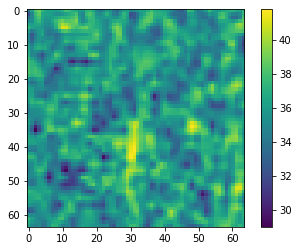

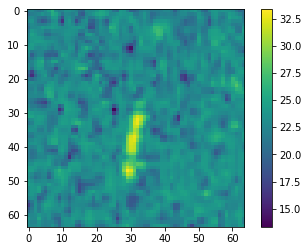

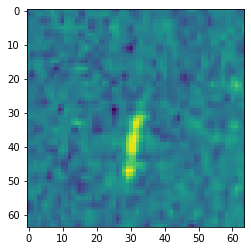

In [12]:
plt.imshow(arr['img'][0,:,:,0])
plt.colorbar()
plt.show()

plt.imshow(arr['img'][0,:,:,1])
plt.colorbar()
plt.show()

plt.imshow(arr['img'][0,:,:,2])
plt.show()

# Write TFRecords

In [15]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
import glob
import numpy as np
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import Progbar

In [29]:
files = glob.glob('/tf/media/ryan/bigboi/datasets/xview3/train/npy_med/*')
# files_train, files_test = train_test_split(files, test_size=0.10, random_state=42)

In [30]:
len(files)

36375

In [31]:
def train_serialize_example(img, label, height, width, id, row, col):
    feature = {
        'img'        : _float_feature(img),
        'img_height' : _int64_feature(height),
        'img_width'  : _int64_feature(width),
        'label'      : _float_feature(label),
        'scene_id'   : _bytes_feature(id),
        'detect_scene_row' :  _int64_feature(row),
        'detect_scene_column' : _int64_feature(col)
    }
    example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
    return example_proto.SerializeToString()

In [32]:
def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
    """Returns a float_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=value))

def _int64_feature(value):
    """Returns an int64_list from a bool / enum / int / uint."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

In [33]:
def read_npy(f):
    arr = np.load(f.numpy().decode(), allow_pickle=True)[()]
    x = arr['img'][0]
    r = arr['detect_scene_row']
    c = arr['detect_scene_column']
    id = arr['scene_id']
    y = arr['label'][0]
    return x, y, r, c, id

In [34]:
def create_datagen(files, shuffle=False, repeat=False, aug=False, batch_size=1):
    
    ds = tf.data.Dataset.from_tensor_slices(files)

    ds = ds.cache()
    
    if repeat:
        ds = ds.repeat()

    if shuffle: 
        ds = ds.shuffle(1024*2)
        opt = tf.data.Options()
        opt.experimental_deterministic = False
        ds = ds.with_options(opt)

    #tokenizer func
    ds = ds.map(lambda f: tf.py_function(func=read_npy,
                                       inp=[f],
                                       Tout=[tf.float32, tf.float32, tf.int64, tf.int64, tf.string]), #tf.int32
                 num_parallel_calls=tf.data.AUTOTUNE)
    
    ds = ds.prefetch(tf.data.AUTOTUNE)

    return ds

In [35]:
BATCH_SIZE = 1
shard_size = 1_000
num_images = len(files)
num_shards = int(np.ceil(num_images/shard_size))

print(f"NUM SHARDS: {num_shards}")

for shard in range(num_shards):
    
    print(f"SHARD: {shard+1}/{num_shards}")
    
    train_gen = create_datagen(files[shard*shard_size:(shard+1)*shard_size],
                               shuffle=False,
                               repeat=False,
                               aug=False,
                               batch_size=1)

    pbar = Progbar(shard_size)
    
    #create writer
    writer = tf.io.TFRecordWriter(f'/tf/media/ryan/bigboi/datasets/xview3/train/tfrecords_med/train_shard_{shard}.tfrec') 
    
    for x, y, r, c, id in train_gen:

        example  = train_serialize_example(img=x.numpy().ravel(),
                                           label=y.numpy().ravel(),
                                           height=x.numpy().shape[0],
                                           width=x.numpy().shape[1],
                                           id=id,
                                           row=r,
                                           col=c)

        writer.write(example)

        pbar.add(1)

NUM SHARDS: 37
SHARD: 1/37
1000/1000 [==============================] - 9s 9ms/step
SHARD: 2/37
1000/1000 [==============================] - 9s 9ms/step
SHARD: 3/37
1000/1000 [==============================] - 9s 9ms/step
SHARD: 4/37
1000/1000 [==============================] - 11s 11ms/step
SHARD: 5/37
1000/1000 [==============================] - 10s 10ms/step
SHARD: 6/37
1000/1000 [==============================] - 10s 9ms/step
SHARD: 7/37
1000/1000 [==============================] - 10s 10ms/step
SHARD: 8/37
1000/1000 [==============================] - 10s 10ms/step
SHARD: 9/37
1000/1000 [==============================] - 10s 10ms/step
SHARD: 10/37
1000/1000 [==============================] - 11s 11ms/step
SHARD: 11/37
1000/1000 [==============================] - 10s 10ms/step
SHARD: 12/37
1000/1000 [==============================] - 10s 10ms/step
SHARD: 13/37
1000/1000 [==============================] - 10s 10ms/step
SHARD: 14/37
1000/1000 [==============================] - 11s 11m

In [26]:
# BATCH_SIZE = 1

# pbar = Progbar(len(files_test))

# #create writer
# writer = tf.io.TFRecordWriter('/tf/media/ryan/SATA1/datasets/xview3/train/tfrecords/val_3chan.tfrec') 

# #create gen
# val_gen = create_datagen(files_test, shuffle=False, repeat=False, aug=False, batch_size=1)

# for x, y in val_gen:

#     example  = train_serialize_example(img=x.numpy().ravel(),
#                                        label=y.numpy().ravel(),
#                                        height=x.numpy().shape[0],
#                                        width=x.numpy().shape[1])
    
#     writer.write(example)

#     pbar.add(1)

In [12]:
def read_labeled_tfrecord(example):
    tfrec_format = {
        'img'        : tf.io.FixedLenSequenceFeature([], tf.float32, allow_missing=True),
        'img_height' : tf.io.FixedLenSequenceFeature([], tf.int64, allow_missing=True),
        'img_width'  : tf.io.FixedLenSequenceFeature([], tf.int64, allow_missing=True),
        'label'      : tf.io.FixedLenSequenceFeature([], tf.float32, allow_missing=True),
        'scene_id'   : tf.io.FixedLenSequenceFeature([], tf.string, allow_missing=True),
        'detect_scene_row' :  tf.io.FixedLenSequenceFeature([], tf.int64, allow_missing=True),
        'detect_scene_column' : tf.io.FixedLenSequenceFeature([], tf.int64, allow_missing=True),
    }
    
    example = tf.io.parse_single_example(example, tfrec_format)
    
    
    h = example['img_height']
    w = example['img_width']
    img = example['img']
    label = example['label']
    id = example['scene_id']
    r = example['detect_scene_row']
    c = example['detect_scene_column']
    
    img = tf.reshape(img, shape=(h[0],w[0],tf.constant(3, dtype=tf.int64)))
    
    return img, label, id, r, c

In [13]:
def get_dataset(files, shuffle = False, repeat = False, 
                labeled=True, return_image_ids=True, batch_size=16):
    
    ds = tf.data.TFRecordDataset(files, num_parallel_reads=tf.data.AUTOTUNE)
    
    ds = ds.cache()
    
    if repeat:
        ds = ds.repeat()
    
    if shuffle: 
        ds = ds.shuffle(1024*2)
        opt = tf.data.Options()
        opt.experimental_deterministic = False
        ds = ds.with_options(opt)
        
    ds = ds.map(lambda example: read_labeled_tfrecord(example), 
                    num_parallel_calls=tf.data.AUTOTUNE)      
    
#     ds = ds.batch(batch_size)

    ds = ds.prefetch(tf.data.AUTOTUNE)
    
    return ds

In [18]:
tfrec_files = glob.glob('/tf/media/ryan/SATA1/datasets/xview3/train/tfrecords/*')
train_tf_gen = get_dataset(tfrec_files,
                           shuffle=False,
                           repeat=False,
                           batch_size=1)

In [93]:
tfrec_files

['/tf/media/ryan/SATA1/datasets/xview3/val/tfrecords/all.tfrec']

In [21]:
from skimage.filters import threshold_yen

In [ ]:
for x, y, r, c, id in train_tf_gen:
    
    print(x.numpy().shape)
    print(y.numpy().shape)
    print(r)
    print(c)
    print(id)
    
    mask = x.numpy()[:,:,1] > threshold_yen(x.numpy()[:,:,1])
    
    plt.figure(figsize=(10,7))
    plt.subplot(1,4,1)
    plt.imshow(x.numpy()[:,:,0])
    plt.subplot(1,4,2)
    plt.imshow(x.numpy()[:,:,1])
    plt.subplot(1,4,3)
    plt.imshow(x.numpy()[:,:,2])
    plt.subplot(1,4,4)
    plt.imshow(mask)
    plt.show()
    
#     break

# Create YoloV5 chips

In [2]:
#train
df = pd.read_csv('/tf/media/ryan/bigboi/datasets/xview3/train/annotations/train.csv')
df = df[df['confidence'].isin(['HIGH', 'MEDIUM'])].reset_index()
df.head()

#val
# df = pd.read_csv('/tf/media/ryan/bigboi/datasets/xview3/val/labels/validation.csv')
# df = df[df['confidence'].isin(['HIGH', 'MEDIUM'])].reset_index()
# df.head()

index  detect_lat  detect_lon  vessel_length_m source  detect_scene_row  \
0      1    5.830786    4.794394              NaN    ais             14867   
1      2    5.650289    5.076500              NaN    ais             16853   
2      3    5.865495    4.938335              NaN    ais             14478   
3      4    5.777973    4.910044              NaN    ais             15447   
4      5    5.745821    4.815893              NaN    ais             15806   

   detect_scene_column is_vessel is_fishing  distance_from_shore_km  \
0                22165     False        NaN             9999.990000   
1                25297     False        NaN                4.120485   
2                23758     False        NaN                4.344042   
3                23448     False        NaN             9999.990000   
4                22406     False        NaN             9999.990000   

            scene_id confidence  top  left  bottom  right  \
0  e42a50089e03990ft       HIGH  NaN   NaN     NaN    NaN   
1  e42a50089e03990ft       HIGH  NaN   NaN     NaN    NaN   
2  e42a50089e03990ft       HIGH  NaN   NaN     NaN    NaN   
3  e42a50089e03990ft       HIGH  NaN   NaN     NaN    NaN   
4  e42a50089e03990ft       HIGH  NaN   NaN     NaN    NaN   

                                           detect_id  
0  e42a50089e03990ft_005.83078557395605034941_004...  
1  e42a50089e03990ft_005.65028885294942995188_005...  
2  e42a50089e03990ft_005.86549528127105990194_004...  
3  e42a50089e03990ft_005.77797292764882008953_004...  
4  e42a50089e03990ft_005.74582138191378977154_004...

In [3]:
#train
vh_files = sorted(glob.glob('/tf/media/ryan/bigboi/datasets/xview3/train/src/*t/VH*tif'))
vv_files = sorted(glob.glob('/tf/media/ryan/bigboi/datasets/xview3/train/src/*t/VV*tif'))

#val
# vh_files = sorted(glob.glob('/tf/media/ryan/bigboi/datasets/xview3/val/src/*v/VH*tif'))
# vv_files = sorted(glob.glob('/tf/media/ryan/bigboi/datasets/xview3/val/src/*v/VV*tif'))

In [4]:
pbar = Progbar(len(vh_files))
# target_img_size = 1280
target_img_size = 640

# bb_sizes = [32, 32, 10]
bb_sizes = [64, 64, 32]

for j, (fil_vv, fil_vh) in enumerate(zip(vv_files, vh_files)):
        
    #get labels
    id_name = os.path.basename(os.path.dirname(fil_vh))
    df_red = df[df['detect_id'].str.contains(id_name)]
    
    labels = df_red[['is_vessel', 'is_fishing']].values    
    cat_labels = np.zeros((labels.shape[0]))
    cat_labels[np.argwhere(np.logical_and(labels[:,0]==False, labels[:,1]==False))] = 0 #NOTHING
    cat_labels[np.argwhere(np.logical_and(labels[:,0]==True, labels[:,1]==False))] = 1  #VESSEL
    cat_labels[np.argwhere(np.logical_and(labels[:,0]==True, labels[:,1]==True))] = 2   #FISHING
    
    if cat_labels.shape[0] == 0:
        pbar.add(1)
        continue
    
    ##################################################read image
    img = rasterio.open(fil_vh).read(1)
    img[img==-32768.0] = 0.0
    
    img_shape = img.shape

    r_pad = target_img_size - (img_shape[0] % target_img_size)
    c_pad = target_img_size - (img_shape[1] % target_img_size)

    img = np.pad(img, [(0,r_pad),(0,c_pad)])

    img[img!=0.0] = img[img!=0.0] - np.amin(img)
    
    #remap to [0,255]
    img = 255*(img - np.amin(img)) / (np.amax(img) - np.amin(img))
    img = img.astype(np.uint8)
    
    #chip the image
    img_vh = patchify(img, patch_size=(target_img_size, target_img_size), step=target_img_size)
    
    del(img)
    gc.collect()
    
    #################################################################
    
    img = rasterio.open(fil_vv).read(1)
    img[img==-32768.0] = 0.0
    
    img_shape = img.shape

    r_pad = target_img_size - (img_shape[0] % target_img_size)
    c_pad = target_img_size - (img_shape[1] % target_img_size)

    img = np.pad(img, [(0,r_pad),(0,c_pad)])

    img[img!=0.0] = img[img!=0.0] - np.amin(img)
    
    #remap to [0,255]
    img = 255*(img - np.amin(img)) / (np.amax(img) - np.amin(img))
    img = img.astype(np.uint8)
    
    #chip the image
    img_vv = patchify(img, patch_size=(target_img_size, target_img_size), step=target_img_size)
    
    del(img)
    gc.collect()
    
    #################################################################

    det_rows, det_cols = df_red.detect_scene_row.values // target_img_size, df_red.detect_scene_column.values // target_img_size
    det_rows_gt, det_cols_gt = df_red.detect_scene_row.values, df_red.detect_scene_column.values
    labels = np.zeros(shape=(img_vh.shape[0], img_vh.shape[1],1))

    for r in range(img_vh.shape[0]):
        for c in range(img_vh.shape[1]):

            if (np.sum(img_vh[r,c]) == 0) or (np.sum(img_vv[r,c]) == 0):
                continue
            
            count = 0
            arr=[]
            for j, (det_r, det_c, det_r_gt, det_c_gt, lab) in enumerate(zip(det_rows, det_cols, det_rows_gt, det_cols_gt, cat_labels)):
                if det_r == r and det_c == c:
                    count += 1

                    #open file
                    annotation = open(f'/tf/media/ryan/bigboi/datasets/xview3/yolov5/datasets/xview3/labels/all_channels/train_640/{id_name}_{r}_{c}.txt', "a")  # append mode
                    
                    #class x_center y_center width height
                    x_center = (det_c_gt - (c*target_img_size)) / target_img_size
                    y_center = (det_r_gt - (r*target_img_size)) / target_img_size
                    width = bb_sizes[int(lab)] / target_img_size
                    height = bb_sizes[int(lab)] / target_img_size
                    annotation.write(f"{lab:0.0f} {x_center} {y_center} {width} {height}\n")
                    
                    #close file
                    annotation.close()
            
            if count != 0:
                #### WRITE OUT IMAGE DATA ####
                jpg_img = np.zeros(shape=(target_img_size,target_img_size,3), dtype=np.uint8)
                jpg_img[:,:,0] = img_vh[r,c]
                jpg_img[:,:,1] = img_vv[r,c]
                jpg_img[:,:,2] = np.sqrt(img_vh[r,c] * img_vv[r,c]).astype(np.uint8)
                jpg_img = Image.fromarray(jpg_img)
                jpg_img.save(f'/tf/media/ryan/bigboi/datasets/xview3/yolov5/datasets/xview3/images/all_channels/train_640/{id_name}_{r}_{c}.jpg')
        
    pbar.add(1)

554/554 [==============================] - 16466s 30s/step


In [5]:
#val
df = pd.read_csv('/tf/media/ryan/bigboi/datasets/xview3/val/labels/validation.csv')
df = df[df['confidence'].isin(['HIGH', 'MEDIUM'])].reset_index()
df.head()

index  detect_lat  detect_lon  vessel_length_m      source  \
0      2   44.288475   13.710885              NaN      manual   
1      3   44.066985   13.249822              NaN  ais/manual   
2      4   44.067516   13.249182              NaN  ais/manual   
3      6   43.968420   12.738374              NaN      manual   
4      7   44.404813   13.438451              NaN  ais/manual   

   detect_scene_row  detect_scene_column is_vessel is_fishing  \
0             10023                28410      True        NaN   
1             12415                24679     False        NaN   
2             12409                24674     False        NaN   
3             13410                20553      True        NaN   
4              8693                26261     False        NaN   

   distance_from_shore_km           scene_id confidence      top     left  \
0             9999.990000  264ed833a13b7f2av     MEDIUM  10018.0  28408.0   
1             9999.990000  264ed833a13b7f2av       HIGH  12412.0  24676.0   
2             9999.990000  264ed833a13b7f2av       HIGH  12406.0  24670.0   
3                0.379794  264ed833a13b7f2av     MEDIUM  13408.0  20551.0   
4             9999.990000  264ed833a13b7f2av       HIGH   8691.0  26258.0   

    bottom    right                                          detect_id  
0  10028.0  28412.0  264ed833a13b7f2av_044.28847472999999723697_013...  
1  12418.0  24683.0  264ed833a13b7f2av_044.06698538999999925636_013...  
2  12412.0  24679.0  264ed833a13b7f2av_044.06751578000000080237_013...  
3  13412.0  20555.0  264ed833a13b7f2av_043.96842029999999823531_012...  
4   8695.0  26264.0  264ed833a13b7f2av_044.40481307000000299468_013...

In [6]:
#val
vh_files = sorted(glob.glob('/tf/media/ryan/bigboi/datasets/xview3/val/src/*v/VH*tif'))
vv_files = sorted(glob.glob('/tf/media/ryan/bigboi/datasets/xview3/val/src/*v/VV*tif'))

In [7]:
pbar = Progbar(len(vh_files))
# target_img_size = 1280
target_img_size = 640

# bb_sizes = [32, 32, 10]
bb_sizes = [64, 64, 32]

for j, (fil_vv, fil_vh) in enumerate(zip(vv_files, vh_files)):
        
    #get labels
    id_name = os.path.basename(os.path.dirname(fil_vh))
    df_red = df[df['detect_id'].str.contains(id_name)]
    
    labels = df_red[['is_vessel', 'is_fishing']].values    
    cat_labels = np.zeros((labels.shape[0]))
    cat_labels[np.argwhere(np.logical_and(labels[:,0]==False, labels[:,1]==False))] = 0 #NOTHING
    cat_labels[np.argwhere(np.logical_and(labels[:,0]==True, labels[:,1]==False))] = 1  #VESSEL
    cat_labels[np.argwhere(np.logical_and(labels[:,0]==True, labels[:,1]==True))] = 2   #FISHING
    
    if cat_labels.shape[0] == 0:
        pbar.add(1)
        continue
    
    ##################################################read image
    img = rasterio.open(fil_vh).read(1)
    img[img==-32768.0] = 0.0
    
    img_shape = img.shape

    r_pad = target_img_size - (img_shape[0] % target_img_size)
    c_pad = target_img_size - (img_shape[1] % target_img_size)

    img = np.pad(img, [(0,r_pad),(0,c_pad)])

    img[img!=0.0] = img[img!=0.0] - np.amin(img)
    
    #remap to [0,255]
    img = 255*(img - np.amin(img)) / (np.amax(img) - np.amin(img))
    img = img.astype(np.uint8)
    
    #chip the image
    img_vh = patchify(img, patch_size=(target_img_size, target_img_size), step=target_img_size)
    
    del(img)
    gc.collect()
    
    #################################################################
    
    img = rasterio.open(fil_vv).read(1)
    img[img==-32768.0] = 0.0
    
    img_shape = img.shape

    r_pad = target_img_size - (img_shape[0] % target_img_size)
    c_pad = target_img_size - (img_shape[1] % target_img_size)

    img = np.pad(img, [(0,r_pad),(0,c_pad)])

    img[img!=0.0] = img[img!=0.0] - np.amin(img)
    
    #remap to [0,255]
    img = 255*(img - np.amin(img)) / (np.amax(img) - np.amin(img))
    img = img.astype(np.uint8)
    
    #chip the image
    img_vv = patchify(img, patch_size=(target_img_size, target_img_size), step=target_img_size)
    
    del(img)
    gc.collect()
    
    #################################################################

    det_rows, det_cols = df_red.detect_scene_row.values // target_img_size, df_red.detect_scene_column.values // target_img_size
    det_rows_gt, det_cols_gt = df_red.detect_scene_row.values, df_red.detect_scene_column.values
    labels = np.zeros(shape=(img_vh.shape[0], img_vh.shape[1],1))

    for r in range(img_vh.shape[0]):
        for c in range(img_vh.shape[1]):

            if (np.sum(img_vh[r,c]) == 0) or (np.sum(img_vv[r,c]) == 0):
                continue
            
            count = 0
            arr=[]
            for j, (det_r, det_c, det_r_gt, det_c_gt, lab) in enumerate(zip(det_rows, det_cols, det_rows_gt, det_cols_gt, cat_labels)):
                if det_r == r and det_c == c:
                    count += 1

                    #open file
                    annotation = open(f'/tf/media/ryan/bigboi/datasets/xview3/yolov5/datasets/xview3/labels/all_channels/test_640/{id_name}_{r}_{c}.txt', "a")  # append mode
                    
                    #class x_center y_center width height
                    x_center = (det_c_gt - (c*target_img_size)) / target_img_size
                    y_center = (det_r_gt - (r*target_img_size)) / target_img_size
                    width = bb_sizes[int(lab)] / target_img_size
                    height = bb_sizes[int(lab)] / target_img_size
                    annotation.write(f"{lab:0.0f} {x_center} {y_center} {width} {height}\n")
                    
                    #close file
                    annotation.close()
            
            if count != 0:
                #### WRITE OUT IMAGE DATA ####
                jpg_img = np.zeros(shape=(target_img_size,target_img_size,3), dtype=np.uint8)
                jpg_img[:,:,0] = img_vh[r,c]
                jpg_img[:,:,1] = img_vv[r,c]
                jpg_img[:,:,2] = np.sqrt(img_vh[r,c] * img_vv[r,c]).astype(np.uint8)
                jpg_img = Image.fromarray(jpg_img)
                jpg_img.save(f'/tf/media/ryan/bigboi/datasets/xview3/yolov5/datasets/xview3/images/all_channels/test_640/{id_name}_{r}_{c}.jpg')
        
    pbar.add(1)

50/50 [==============================] - 1499s 30s/step


## Change bbox height/width

In [3]:
files = glob.glob('/tf/media/ryan/bigboi/datasets/xview3/yolov5/datasets/xview3/labels/vh_only/train/*txt')
pbar = Progbar(len(files))

for f in files:
    df = pd.read_csv(f, delimiter=' ', names=['class', 'x_center', 'y_center', 'width', 'height'])
    
#     if np.isnan(df.x_center.values[0]):
#         df = pd.read_csv(f, delimiter=',').iloc[:,1:]
#     else:
#         pbar.add(1)
#         continue
    
    df.loc[df['class']==0, ['width', 'height']] = 64/1280
    df.loc[df['class']==1, ['width', 'height']] = 64/1280
    df.loc[df['class']==2, ['width', 'height']] = 32/1280
    
    df.to_csv(f, index=False, header=None, sep=' ')
    
    pbar.add(1)

26634/26634 [==============================] - 423s 16ms/step


In [4]:
files = glob.glob('/tf/media/ryan/bigboi/datasets/xview3/yolov5/datasets/xview3/labels/vh_only/test/*txt')
pbar = Progbar(len(files))

for f in files:
    df = pd.read_csv(f, delimiter=' ', names=['class', 'x_center', 'y_center', 'width', 'height'])
    
    df.loc[df['class']==0, ['width', 'height']] = 64/1280
    df.loc[df['class']==1, ['width', 'height']] = 64/1280
    df.loc[df['class']==2, ['width', 'height']] = 32/1280
    
    df.to_csv(f, index=False, header=None, sep=' ')
    
    pbar.add(1)

3790/3790 [==============================] - 27s 7ms/step


# Change third channel

In [34]:
files = glob.glob(f'/tf/media/ryan/bigboi/datasets/xview3/yolov5/datasets/xview3/images/all_channels/train/*.jpg')
pbar = Progbar(len(files))

for i, f in enumerate(files):
    img = np.array(Image.open(f))
    
    #correctly compute "cross corr"
    img_cc = np.sqrt(img[:,:,0].astype(np.float32)*img[:,:,1].astype(np.float32)).astype(np.uint8)

    #overwrite content
    img[:,:,-1] = img_cc
    
    jpg_img = Image.fromarray(img)
    jpg_img.save(f)

    pbar.add(1)

26634/26634 [==============================] - 2176s 82ms/step


In [10]:
files = glob.glob(f'/tf/media/ryan/bigboi/datasets/xview3/yolov5/datasets/xview3/images/all_channels/public_lb/*.jpg')
pbar = Progbar(len(files))

for i, f in enumerate(files):
    
    name = os.path.basename(f)
    new_path = os.path.dirname(f)[:-9]+'lb/rev/'+name
    
    img = np.array(Image.open(f))
    
    #correctly compute "cross corr"
    img_cc = np.sqrt(img[:,:,0].astype(np.float32)*img[:,:,1].astype(np.float32)).astype(np.uint8)

    #overwrite content
    img[:,:,-1] = img_cc
    
    
    jpg_img = Image.fromarray(img)
    jpg_img.save(new_path)

    pbar.add(1)

45817/45817 [==============================] - 3708s 81ms/step


### Public Leaderboard image chipper

In [9]:
#LB
vh_files = sorted(glob.glob('/tf/media/ryan/bigboi/datasets/xview3/public/src/*p/VH*tif'))
vv_files = sorted(glob.glob('/tf/media/ryan/bigboi/datasets/xview3/public/src/*p/VV*tif'))

In [10]:
pbar = Progbar(len(vh_files))
target_img_size = 640

for j, (fil_vv, fil_vh) in enumerate(zip(vv_files, vh_files)):
        
    #get labels
    id_name = os.path.basename(os.path.dirname(fil_vh))
    
    ##################################################read image
    img = rasterio.open(fil_vh).read(1)
    img[img==-32768.0] = 0.0
    
    img_shape = img.shape

    r_pad = target_img_size - (img_shape[0] % target_img_size)
    c_pad = target_img_size - (img_shape[1] % target_img_size)

    img = np.pad(img, [(0,r_pad),(0,c_pad)])

    img[img!=0.0] = img[img!=0.0] - np.amin(img)
    
    #remap to [0,255]
    img = 255*(img - np.amin(img)) / (np.amax(img) - np.amin(img))
    img = img.astype(np.uint8)
    
    #chip the image
    img_vh = patchify(img, patch_size=(target_img_size, target_img_size), step=target_img_size)
    
    del(img)
    gc.collect()
    
    #################################################################
    
    img = rasterio.open(fil_vv).read(1)
    img[img==-32768.0] = 0.0
    
    img_shape = img.shape

    r_pad = target_img_size - (img_shape[0] % target_img_size)
    c_pad = target_img_size - (img_shape[1] % target_img_size)

    img = np.pad(img, [(0,r_pad),(0,c_pad)])

    img[img!=0.0] = img[img!=0.0] - np.amin(img)
    
    #remap to [0,255]
    img = 255*(img - np.amin(img)) / (np.amax(img) - np.amin(img))
    img = img.astype(np.uint8)
    
    #chip the image
    img_vv = patchify(img, patch_size=(target_img_size, target_img_size), step=target_img_size)
    
    del(img)
    gc.collect()
    
    for r in range(img_vh.shape[0]):
        for c in range(img_vh.shape[1]):

            if (np.sum(img_vh[r,c]) == 0) or (np.sum(img_vv[r,c]) == 0):
                continue
                        
            #WRITE OUT IMAGE DATA
            jpg_img = np.zeros(shape=(target_img_size,target_img_size,3), dtype=np.uint8)
            jpg_img[:,:,0] = img_vh[r,c]
            jpg_img[:,:,1] = img_vv[r,c]
            jpg_img[:,:,2] = np.sqrt(img_vh[r,c] * img_vv[r,c]).astype(np.uint8)
            jpg_img = Image.fromarray(jpg_img)
            jpg_img.save(f'/tf/media/ryan/bigboi/datasets/xview3/yolov5/datasets/xview3/images/all_channels/public_lb_640/{id_name}_{r}_{c}.jpg')
        
    pbar.add(1)

150/150 [==============================] - 7381s 49s/step


In [8]:
import shutil

In [10]:
pop_labels = glob.glob('/tf/media/ryan/bigboi/datasets/xview3/yolov5/datasets/xview3/labels/train/*')
ids=[]
for l in pop_labels:
    id_name = os.path.basename(l)[:-4]
    
    source = f'/tf/media/ryan/bigboi/datasets/xview3/yolov5/datasets/xview3/images/train/{id_name}.jpg'
    destination = f'/tf/media/ryan/bigboi/datasets/xview3/yolov5/datasets/xview3/images/train_populated/{id_name}.jpg'
    
    shutil.copyfile(source, destination)

In [6]:
ids

['8902ea166d048743t_7_4',
 '0222c037f32357b7t_13_4',
 'fafc240a3e4dee41t_7_18',
 '351c9bfded60c563t_4_5',
 '10615061cd28e01bt_3_3',
 '793f931ebbc36eedt_7_13',
 '32757383221a9c49t_14_11',
 '2757e53eccea715dt_3_2',
 '5dcbc770ae8216f7t_13_9',
 'a791f9b908c03325t_16_7',
 '3ef755faadd6cc14t_8_2',
 'c955676015f56b2et_16_18',
 'a1dfd3c832f17b5et_2_7',
 '2e65e3387885c951t_13_15',
 '7fd0069c92e5c65et_13_21',
 'ee80b25767f4d1act_10_9',
 'b44881f238ef0beet_6_8',
 '9c4703bf071fc332t_13_16',
 'c02417eaffffc8bat_4_11',
 'a8d09b13ad09a61ft_2_5',
 '99e2878f43a8dea8t_15_19',
 '2398ea5e6161fce1t_3_8',
 'a01f78741f8c5fd0t_10_6',
 '376ccdadb72ceb7ct_10_10',
 'ff55662cc239f09bt_5_7',
 'ed69eae9b34dbe1dt_3_8',
 'cef19abab25e4e41t_18_15',
 'ef43fc465a606f43t_13_2',
 '3ad5477688c0f037t_11_13',
 '821593907c14c5c2t_8_11',
 '298cc8fe01c22ffat_4_8',
 'bd935f0ae1205861t_8_1',
 'bc3cf9dc5abd3c65t_4_6',
 '1e609174508bdc98t_12_10',
 '1f1ef57de714f5c2t_4_4',
 '689303f07e882115t_8_11',
 '8cbafe5678dfaa68t_13_13',
 '0dd

# Create large-scale image chips

In [2]:
df = pd.read_csv('/tf/media/ryan/bigboi/datasets/xview3/val/labels/validation.csv')
df.head()

detect_lat  detect_lon  vessel_length_m      source  detect_scene_row  \
0   44.287964   13.041733              NaN      manual              9923   
1   44.617888   12.357101              NaN      manual              6105   
2   44.288475   13.710885              NaN      manual             10023   
3   44.066985   13.249822              NaN  ais/manual             12415   
4   44.067516   13.249182              NaN  ais/manual             12409   

   detect_scene_column is_vessel is_fishing  distance_from_shore_km  \
0                23071      True        NaN             9999.990000   
1                17727      True        NaN                6.252201   
2                28410      True        NaN             9999.990000   
3                24679     False        NaN             9999.990000   
4                24674     False        NaN             9999.990000   

            scene_id confidence      top     left   bottom    right  \
0  264ed833a13b7f2av        LOW   9918.0  23068.0   9928.0  23074.0   
1  264ed833a13b7f2av        LOW   6099.0  17725.0   6111.0  17729.0   
2  264ed833a13b7f2av     MEDIUM  10018.0  28408.0  10028.0  28412.0   
3  264ed833a13b7f2av       HIGH  12412.0  24676.0  12418.0  24683.0   
4  264ed833a13b7f2av       HIGH  12406.0  24670.0  12412.0  24679.0   

                                           detect_id  
0  264ed833a13b7f2av_044.28796374000000213300_013...  
1  264ed833a13b7f2av_044.61788760999999681189_012...  
2  264ed833a13b7f2av_044.28847472999999723697_013...  
3  264ed833a13b7f2av_044.06698538999999925636_013...  
4  264ed833a13b7f2av_044.06751578000000080237_013...

In [3]:
vh_files = glob.glob('/tf/media/ryan/bigboi/datasets/xview3/val/src/*v/VH*tif')
vv_files = glob.glob('/tf/media/ryan/bigboi/datasets/xview3/val/src/*v/VV*tif')

In [4]:
vv_files

['/tf/media/ryan/bigboi/datasets/xview3/val/src/204e657a411faf4dv/VV_dB.tif',
 '/tf/media/ryan/bigboi/datasets/xview3/val/src/590dd08f71056cacv/VV_dB.tif',
 '/tf/media/ryan/bigboi/datasets/xview3/val/src/377410f6ab9824dfv/VV_dB.tif',
 '/tf/media/ryan/bigboi/datasets/xview3/val/src/cd36e75010a021f7v/VV_dB.tif',
 '/tf/media/ryan/bigboi/datasets/xview3/val/src/3ceef682fbe4930av/VV_dB.tif',
 '/tf/media/ryan/bigboi/datasets/xview3/val/src/39268d50efe8dae9v/VV_dB.tif',
 '/tf/media/ryan/bigboi/datasets/xview3/val/src/e40c9251a4fce150v/VV_dB.tif',
 '/tf/media/ryan/bigboi/datasets/xview3/val/src/cdc04ca397865356v/VV_dB.tif',
 '/tf/media/ryan/bigboi/datasets/xview3/val/src/4a97701b4bd81bf7v/VV_dB.tif',
 '/tf/media/ryan/bigboi/datasets/xview3/val/src/4da9db72dea50504v/VV_dB.tif',
 '/tf/media/ryan/bigboi/datasets/xview3/val/src/0e309957cef7bdc8v/VV_dB.tif',
 '/tf/media/ryan/bigboi/datasets/xview3/val/src/5e9a2c1bcf179e9bv/VV_dB.tif',
 '/tf/media/ryan/bigboi/datasets/xview3/val/src/b1844cde847a3942

In [5]:
len(vv_files)

50

In [6]:
from patchify import patchify

In [7]:
pbar = Progbar(len(vv_files))

for vv_f, vh_f in zip(vv_files, vh_files):
    
    for j, fil in enumerate([vv_f, vh_f]):

        if j ==0:
            name='vv'
        else:
            name='vh'
        
        #get labels
        id_name = os.path.basename(os.path.dirname(fil))
        df_red = df[df['detect_id'].str.contains(id_name)]
        df_red['is_fishing'] = df_red['is_fishing'].fillna(False)
        df_red['is_vessel'] = df_red['is_vessel'].fillna(False)

        ###### VV Channel ######
        
#         base = os.path.dirname(fil)
#         img = rasterio.open(base+'/owiMask.tif').read(1)
#         img[img==-32768.0] = -1000
#         img = img > 0.0
#         img_shape = img.shape
#         img = Image.fromarray(img)
#         img = img.resize((img_shape[1]*50, img_shape[0]*50), Image.BILINEAR)
#         img = np.array(img)


        img = rasterio.open(fil).read(1)
        img[img==-32768.0] = 0.0
        img_shape = img.shape
#################################################
        
        r_pad = 1500 - (img_shape[0] % 1500)
        c_pad = 1500 - (img_shape[1] % 1500)

        img = np.pad(img, [(0,r_pad),(0,c_pad)])

        img[img!=0.0] = img[img!=0.0] - np.amin(img)
        print(img.shape)

        #chip the image
        img = patchify(img, patch_size=(1500,1500), step=1500)

        det_rows, det_cols = df_red.detect_scene_row.values // 1500, df_red.detect_scene_column.values // 1500
        det_rows_gt, det_cols_gt = df_red.detect_scene_row.values, df_red.detect_scene_column.values
        labels = np.zeros(shape=(img.shape[0], img.shape[1],1))

        for r in range(img.shape[0]):
            for c in range(img.shape[1]):

                count = 0
                arr=[]
                for j, (det_r, det_c, det_r_gt, det_c_gt) in enumerate(zip(det_rows, det_cols, det_rows_gt, det_cols_gt)):
                    if det_r == r and det_c == c:
                        count += 1
                        arr.append((det_r_gt - (r*1500), det_c_gt - (c*1500)))
                
                if len(arr) != 0:
                    np.save(f'/tf/media/ryan/bigboi/datasets/xview3/val/large_scale/npy2/{id_name}_{r}_{c}_annotation.npy', arr)
            
                if count == 0:
                    arr = {'img': img[r,c], 'label': 0.0}
                else:
                    arr = {'img': img[r,c], 'label': 1.0}
    
                if np.sum(img[r,c]) != 0.0:
                    np.save(f'/tf/media/ryan/bigboi/datasets/xview3/val/large_scale/npy2/{id_name}_{r}_{c}_{name}.npy', arr)

        #mask
#         for r in range(img.shape[0]):
#             for c in range(img.shape[1]):                
#                 if np.sum(img[r,c]) != 0.0:
#                     arr = {'img': img[r,c], 'label': 1.0}
#                     np.save(f'/tf/media/ryan/bigboi/datasets/xview3/val/large_scale/npy/{id_name}_{r}_{c}_mask.npy', arr)
                
    pbar.add(1)
    
    break

/root/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/root/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


(22500, 31500)
(22500, 31500)
 1/50 [..............................] - ETA: 53:28

In [24]:
img_mask.shape

(21600, 29500)

In [12]:
img.shape

(21597, 29486)

In [19]:
from skimage.filters import try_all_threshold, threshold_yen
from skimage.segmentation import morphological_geodesic_active_contour

False


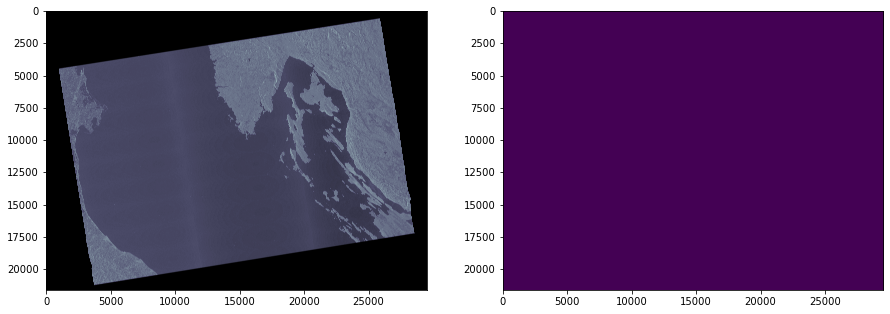

In [16]:
plt.figure(figsize=(15,15))

plt.subplot(1,2,1)
# plt.title(y.numpy().ravel())
plt.imshow(img, cmap='bone')

plt.subplot(1,2,2)

print(np.isnan(img).any())

mask = img > 69.55954
plt.imshow(mask)
plt.show()

In [ ]:
cont = morphological_geodesic_active_contour(img, iterations=10)

/root/miniconda3/lib/python3.7/site-packages/skimage/segmentation/morphsnakes.py:106: FutureWarning: circle_level_set is deprecated in favor of disk_level_set.circle_level_set will be removed in version 0.19
  res = circle_level_set(image_shape)


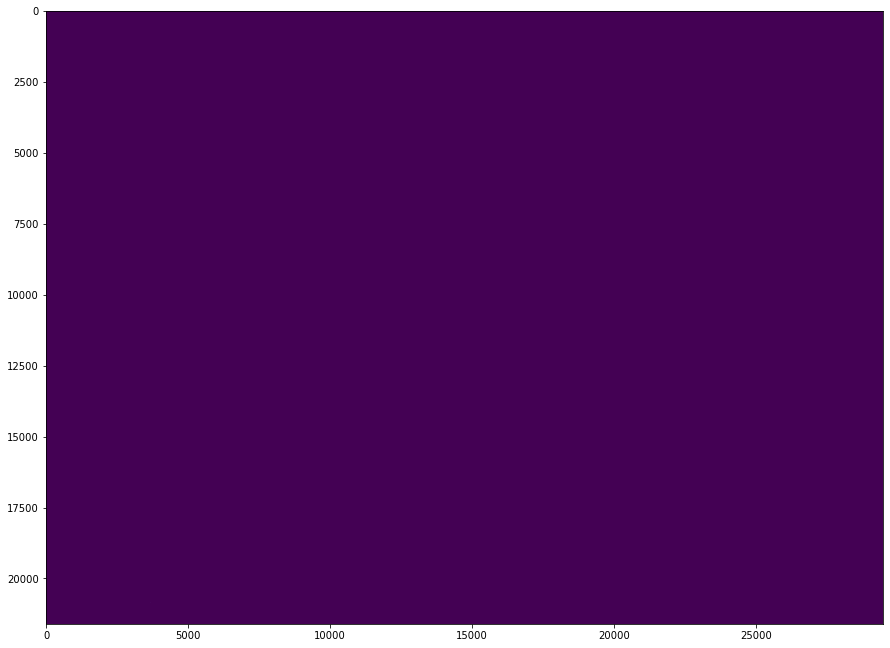

In [17]:
plt.figure(figsize=(15,15))
plt.imshow(mask)
plt.show()

In [15]:
threshold_yen(img[img!=0.0])

69.55954

# Create clutter chips

In [1]:
import rasterio
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
from sarpy.visualization.remap import density
import pandas as pd
import glob
import os
import tensorflow as tf
from tensorflow.keras.utils import Progbar
from PIL import Image
from patchify import patchify
import cv2
import time

In [3]:
shoreline = np.load('/tf/media/ryan/bigboi/datasets/xview3/shoreline/validation/0157baf3866b2cf9v_shoreline.npy', allow_pickle=True)

In [8]:
shoreline[0].shape

(70190, 2)

In [2]:
df = pd.read_csv('/tf/media/ryan/bigboi/datasets/xview3/train/annotations/train.csv')
df.head()

detect_lat  detect_lon  vessel_length_m source  detect_scene_row  \
0    5.662924    4.842429              NaN    ais             16722   
1    5.830786    4.794394              NaN    ais             14867   
2    5.650289    5.076500              NaN    ais             16853   
3    5.865495    4.938335              NaN    ais             14478   
4    5.777973    4.910044              NaN    ais             15447   

   detect_scene_column is_vessel is_fishing  distance_from_shore_km  \
0                22703       NaN        NaN             9999.990000   
1                22165     False        NaN             9999.990000   
2                25297     False        NaN                4.120485   
3                23758     False        NaN                4.344042   
4                23448     False        NaN             9999.990000   

            scene_id confidence  top  left  bottom  right  \
0  e42a50089e03990ft        LOW  NaN   NaN     NaN    NaN   
1  e42a50089e03990ft       HIGH  NaN   NaN     NaN    NaN   
2  e42a50089e03990ft       HIGH  NaN   NaN     NaN    NaN   
3  e42a50089e03990ft       HIGH  NaN   NaN     NaN    NaN   
4  e42a50089e03990ft       HIGH  NaN   NaN     NaN    NaN   

                                           detect_id  
0  e42a50089e03990ft_005.66292355123628965430_004...  
1  e42a50089e03990ft_005.83078557395605034941_004...  
2  e42a50089e03990ft_005.65028885294942995188_005...  
3  e42a50089e03990ft_005.86549528127105990194_004...  
4  e42a50089e03990ft_005.77797292764882008953_004...

In [3]:
df.scene_id.unique()

array(['e42a50089e03990ft', '3ff1ba62d8d3fe15t', '00a035722196ee86t',
       '5d7acea796201046t', '7adee9ec4133b2f5t', '6f3e6b05cf9d127at',
       'bd24c2e8d539f972t', 'e5ee19f0c67db895t', 'b71fc521ffaf08c6t',
       'bc3cf9dc5abd3c65t', '4518c556b38a5fa4t', 'ad53bfd630e65f56t',
       '68131f10aed5c5a2t', 'f088cc4cf43ba7a3t', '59956f169e0bef5ct',
       'c0869b2f6131bc1ft', 'a45bc46512eb61f8t', '5424f99dfa42740bt',
       'c509afa2ac424339t', '91bbc8bbf928daa7t', 'da781384de903b8dt',
       '2f53eb6658f5d979t', '6ffc913c4655b43ft', 'efe75c178f7117a7t',
       '7990e9589b9ff3bft', '63ad51bc14ca8b5dt', 'e5e4bf0c579362bdt',
       '20c5257d1ce48655t', 'c470441906b228bct', 'f16fe7fee9a1af85t',
       '81f64a8d90b22463t', '9817cbd5b4d6b39bt', 'c9ba0778c396fd2dt',
       '0d7a0261c60d39det', '52d56395768fb8a7t', '2dbf62ac709047c5t',
       '1b24d3aa597c472dt', '7b4768c0684c4202t', '3dff8354d244a4b1t',
       'a92edc51bc96a82ft', '560196fa56af9f03t', '90c677f83c4e18a9t',
       'd566639ea7b7

In [4]:
from scipy.ndimage.filters import uniform_filter
from scipy.ndimage.measurements import variance

def lee_filter(img, size):
    img_mean = uniform_filter(img, (size, size))
    img_sqr_mean = uniform_filter(img**2, (size, size))
    img_variance = img_sqr_mean - img_mean**2

    overall_variance = variance(img)

    img_weights = img_variance / (img_variance + overall_variance)
    img_output = img_mean + img_weights * (img - img_mean)
    return img_output

In [ ]:
names=['VV','VH']
base_path = '/tf/media/ryan/bigboi/datasets/xview3/train/src/'

unique_ids = df.scene_id.unique()

for q, id in enumerate(unique_ids):
    
    if q == 0: #or q == 1:
        continue
        
    print(f"ID: {id}")
    
    df_red = df[df['scene_id'].str.contains(id)]
    
#     bad_idx = set()
#     for n, name in enumerate(names):

#     print(f"Reading: /tf/media/ryan/bigboi/datasets/xview3/train/src/{id}/VV_dB.tif")

    #get metadata
    bath_path = base_path+id+'/bathymetry.tif'
    wind_dir_path = base_path+id+'/owiWindDirection.tif'
    wind_qual_path = base_path+id+'/owiWindQuality.tif'
    wind_speed_path = base_path+id+'/owiWindSpeed.tif'

    meta_img_bath = rasterio.open(bath_path).read(1)
    meta_img_bath[meta_img_bath==-32768.0] = 0.0

    meta_img_wind_dir = rasterio.open(wind_dir_path).read(1)
    meta_img_wind_dir[meta_img_wind_dir==-32768.0] = 0.0

    meta_img_wind_qual = rasterio.open(wind_qual_path).read(1)
    meta_img_wind_qual[meta_img_wind_qual==-32768.0] = 0.0

    meta_img_wind_speed = rasterio.open(wind_speed_path).read(1)
    meta_img_wind_speed[meta_img_wind_speed==-32768.0] = 0.0


    #get full size images
    img = rasterio.open(f'/tf/media/ryan/bigboi/datasets/xview3/train/src/{id}/VV_dB.tif').read(1)
    img[img==-32768.0] = 0.0
    img[img!=0.0] = img[img!=0.0] - np.amin(img[img!=0.0])

    #zero out detected ROIs
    for r, c in zip(df_red.detect_scene_row.values, df_red.detect_scene_column.values):
        img[r-32:r+32,c-32:c+32] = 0.0

    #patch images
    patches_vv = patchify(img, (1500, 1500), step=1500)
#     patches_vv = patches_vv.reshape((patches_vv.shape[0]*patches_vv.shape[1],1500,1500))
    
    #kill the large image
#     del img
    img=0
    
#     print(f"Reading: /tf/media/ryan/bigboi/datasets/xview3/train/src/{id}/VH_dB.tif")

    img = rasterio.open(f'/tf/media/ryan/bigboi/datasets/xview3/train/src/{id}/VH_dB.tif').read(1)
    img[img==-32768.0] = 0.0
    img[img!=0.0] = img[img!=0.0] - np.amin(img[img!=0.0])

    #zero out detected ROIs
    for r, c in zip(df_red.detect_scene_row.values, df_red.detect_scene_column.values):
        img[r-32:r+32,c-32:c+32] = 0.0

    #patch images
    patches_vh = patchify(img, (1500, 1500), step=1500)
#     patches_vh = patches_vh.reshape((patches_vh.shape[0]*patches_vh.shape[1],1500,1500))
    
    num_patches = patches_vh.shape[0]*patches_vh.shape[1]
    
    #kill the large image
    img=0

    pbar = Progbar(num_patches)
    
#     for i, (p_vv, p_vh) in enumerate(zip(patches_vv, patches_vh)):
    for p_r in range(patches_vh.shape[0]):
        for p_c in range(patches_vh.shape[1]):

            #get patch in VV/VH
            p_vv = patches_vv[p_r][p_c]
            p_vh = patches_vh[p_r][p_c]
            
            if (np.sum(p_vv) == 0.0) or (np.sum(p_vh) == 0.0):
                #pass if padding patch
                pbar.add(1)
                continue

            #apply lee filter for smoothing/denoising
            img_vv_lee = lee_filter(p_vv, 5)
            img_vh_lee = lee_filter(p_vh, 5)

            #norm to [0,255] dyn range
            img_vv_lee = (255*(img_vv_lee - np.amin(img_vv_lee)) / (np.amax(img_vv_lee) - np.amin(img_vv_lee))).astype(np.uint8)
            img_vh_lee = (255*(img_vh_lee - np.amin(img_vh_lee)) / (np.amax(img_vh_lee) - np.amin(img_vh_lee))).astype(np.uint8)

            #create SIFT feature extractor
            sift_vv = cv2.xfeatures2d.SIFT_create()
            sift_vh = cv2.xfeatures2d.SIFT_create()

            #get keypoints
            kps_all = []
            kps_vv, des_vv = sift_vv.detectAndCompute(img_vv_lee, None)
            kps_all.extend(kps_vv[:50]) #append only first 250

            kps_vh, des_vh = sift_vh.detectAndCompute(img_vh_lee, None)
            kps_all.extend(kps_vh[:50]) #append only first 250

            #iterate through SIFT keypoints
            for k, kp in enumerate(kps_all):
                #get the keypoint
                l_c, l_r = kp.pt
                l_c, l_r = int(l_c), int(l_r)

                lr_min = l_r-32
                lr_max = l_r+32
                lc_min = l_c-32
                lc_max = l_c+32

                if lr_min < 0:
                    lr_min = 0
                elif lr_max > 1500:
                    lr_max = 1500

                if lc_min < 0:
                    lc_min = 0
                elif lc_max > 1500:
                    lc_max = 1500

                #get the sub image
                sub_vv_img = p_vv[lr_min:lr_max,lc_min:lc_max]
                sub_vh_img = p_vh[lr_min:lr_max,lc_min:lc_max]

                if (0.0 in sub_vv_img) or (0.0 in sub_vh_img):
                    #if any padding in either then skip
                    continue

                #pad the subimage
                if (sub_vv_img.shape[0] != 64) or (sub_vv_img.shape[1] != 64):
                    try:
                        sub_vv_img = np.pad(sub_vv_img, ((0,64-sub_vv_img.shape[0]),(0,64-sub_vv_img.shape[1])), mode='reflect')
                    except:
                        #last resort since i dont want 0 values in the patches since this will mess
                        #up the inherent statistical distributions of the physical returns in the ROI
                        #could skip instead but ill choose to pad for now as not anticipating a lot of these edge patches
                        sub_vv_img = np.pad(sub_vv_img, ((0,64-sub_vv_img.shape[0]),(0,64-sub_vv_img.shape[1])), mode='constant', constant_values=0.0)

                if (sub_vh_img.shape[0] != 64) or (sub_vh_img.shape[1] != 64):
                    try:
                        sub_vh_img = np.pad(sub_vh_img, ((0,64-sub_vh_img.shape[0]),(0,64-sub_vh_img.shape[1])), mode='reflect')
                    except:
                        sub_vh_img = np.pad(sub_vh_img, ((0,64-sub_vh_img.shape[0]),(0,64-sub_vh_img.shape[1])), mode='constant', constant_values=0.0)

                #get the save/load path of the npy array
                path = f'/tf/media/ryan/bigboi/datasets/xview3/train/clutter_chips/npy_all/{id}_{p_r}_{p_c}_{k}.npy'

                img_ = np.zeros((64,64,2))

                #write out 0th channel
                img_[:,:,0] = sub_vv_img
                img_[:,:,1] = sub_vh_img

                #get global spatial offsets based on patch rows and cols
                global_row_offset = p_r * 1500
                global_col_offset = p_c * 1500
                
                #get reduced res row/col
                meta_lr = (l_r + global_row_offset) // 50
                meta_lc = (l_c + global_col_offset) // 50

                bathymetry = meta_img_bath[meta_lr, meta_lc]
                owiWindDirection = meta_img_wind_dir[meta_lr, meta_lc]
                owiWindQuality = meta_img_wind_qual[meta_lr, meta_lc]
                owiWindSpeed = meta_img_wind_speed[meta_lr, meta_lc]

                arr = {'img':img_, 'scene_id':id, 'patch_row_number':{p_r}, 'patch_row_number':{p_c},
                       'detect_scene_row':l_r, 'detect_scene_column':l_c,
                       'bathymetry':bathymetry, 'owiWindDirection':owiWindDirection,
                       'owiWindQuality':owiWindQuality, 'owiWindSpeed':owiWindSpeed}

                #save the dict out
                np.save(path, arr, allow_pickle=True)

            pbar.add(1)
    
    patches_vv=0
    patches_vh=0
        
#     break

ID: 3ff1ba62d8d3fe15t
252/252 [==============================] - 240s 956ms/step
ID: 00a035722196ee86t


In [9]:
arr

{'img': array([[[39.109375  , 36.7421875 ],
         [37.734375  , 35.6484375 ],
         [37.5703125 , 32.75      ],
         ...,
         [39.34375   , 31.53125   ],
         [37.859375  , 30.4375    ],
         [37.6171875 , 31.046875  ]],
 
        [[37.4140625 , 37.21875   ],
         [36.8515625 , 35.6875    ],
         [38.0390625 , 32.03125   ],
         ...,
         [40.140625  , 31.1875    ],
         [38.9609375 , 30.171875  ],
         [38.7265625 , 30.25      ]],
 
        [[36.8984375 , 36.2265625 ],
         [36.765625  , 34.8671875 ],
         [38.1328125 , 31.71875   ],
         ...,
         [39.609375  , 31.046875  ],
         [38.6484375 , 30.109375  ],
         [38.734375  , 30.1875    ]],
 
        ...,
 
        [[41.96875   , 30.8125    ],
         [42.50390625, 31.5625    ],
         [42.8203125 , 32.6875    ],
         ...,
         [44.8671875 , 32.296875  ],
         [44.07421875, 31.890625  ],
         [43.33984375, 32.796875  ]],
 
        [[47.24804688,

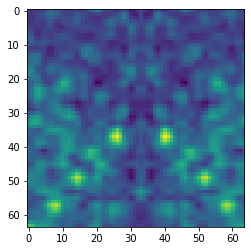

In [7]:
plt.imshow(sub_vv_img)

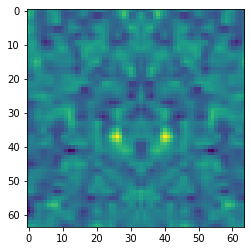

In [8]:
plt.imshow(sub_vh_img)

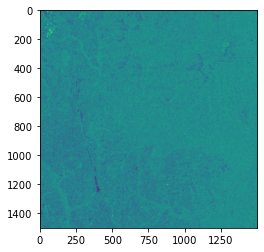

In [14]:
plt.imshow(p_vh)

In [10]:
sub_vv_img

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [8]:
sub_vv_img.shape

(64, 64)

In [7]:
sub_vh_img.shape

(64, 0)

In [12]:
kps_vv.extend(list(kps_vh))

In [14]:
len(kps_vv)

10138

In [7]:
df_red = df[df['scene_id'].str.contains('e42a50089e03990ft')] #('128443d1e98e2839v')]
df_red.head()

detect_lat  detect_lon  vessel_length_m source  detect_scene_row  \
0    5.662924    4.842429              NaN    ais             16722   
1    5.830786    4.794394              NaN    ais             14867   
2    5.650289    5.076500              NaN    ais             16853   
3    5.865495    4.938335              NaN    ais             14478   
4    5.777973    4.910044              NaN    ais             15447   

   detect_scene_column is_vessel is_fishing  distance_from_shore_km  \
0                22703       NaN        NaN             9999.990000   
1                22165     False        NaN             9999.990000   
2                25297     False        NaN                4.120485   
3                23758     False        NaN                4.344042   
4                23448     False        NaN             9999.990000   

            scene_id confidence  top  left  bottom  right  \
0  e42a50089e03990ft        LOW  NaN   NaN     NaN    NaN   
1  e42a50089e03990ft       HIGH  NaN   NaN     NaN    NaN   
2  e42a50089e03990ft       HIGH  NaN   NaN     NaN    NaN   
3  e42a50089e03990ft       HIGH  NaN   NaN     NaN    NaN   
4  e42a50089e03990ft       HIGH  NaN   NaN     NaN    NaN   

                                           detect_id  
0  e42a50089e03990ft_005.66292355123628965430_004...  
1  e42a50089e03990ft_005.83078557395605034941_004...  
2  e42a50089e03990ft_005.65028885294942995188_005...  
3  e42a50089e03990ft_005.86549528127105990194_004...  
4  e42a50089e03990ft_005.77797292764882008953_004...

In [ ]:
del img_vv

In [51]:
img_vv = rasterio.open(f'/tf/media/ryan/bigboi/datasets/xview3/train/src/e42a50089e03990ft/VH_dB.tif').read(1)
# img_vh = rasterio.open('/tf/media/ryan/bigboi/datasets/xview3/public/src/02649c5fc4f85dadp/VH_dB.tif')

img_vv[img_vv==-32768.0] = -1.0
img_vv[img_vv!=-1.0] = img_vv[img_vv!=-1.0] - np.amin(img_vv[img_vv!=-1.0])

In [52]:
img_vv.shape

(24510, 28674)

In [53]:
for r, c in zip(df_red.detect_scene_row.values, df_red.detect_scene_column.values):
    img_vv[r-32:r+32,c-32:c+32]=-1.0

In [ ]:
plt.figure(figsize=(20,20))
# plt.imshow(np.abs(vh)[10000:11000,10000:11000], cmap='bone')
plt.imshow(img_vv, cmap='bone')
plt.colorbar()
plt.show()

In [56]:
patches = patchify(img_vv, (64, 64), step=64)#.reshape((195*85,64,64,1))
patches = patches.reshape((patches.shape[0]*patches.shape[1],64,64,1))

In [57]:
np.amin(patches)

-1.0

In [58]:
np.amax(patches)

70.375

In [59]:
patches.shape

(171136, 64, 64, 1)

In [ ]:
(171136, 64, 64, 1)

In [54]:
(171136, 64, 64, 1)

(171136, 64, 64, 1)

In [47]:
# good_idx = []
# for i, p in enumerate(patches):
#     if -1.0 not in p:
#         good_idx.append(i)

In [60]:
patches[good_idx].shape

(114700, 64, 64, 1)

In [61]:
np.save('./clutter_patches_vh.npy', patches[good_idx])

In [ ]:
# (114989, 64, 64, 1)

In [ ]:
# VV: (114700, 64, 64, 1)

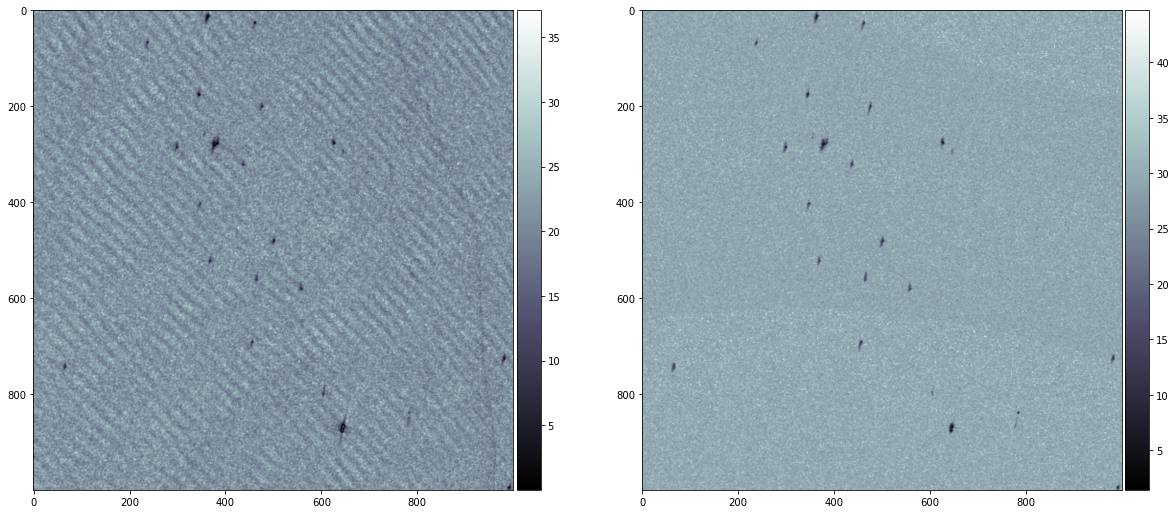

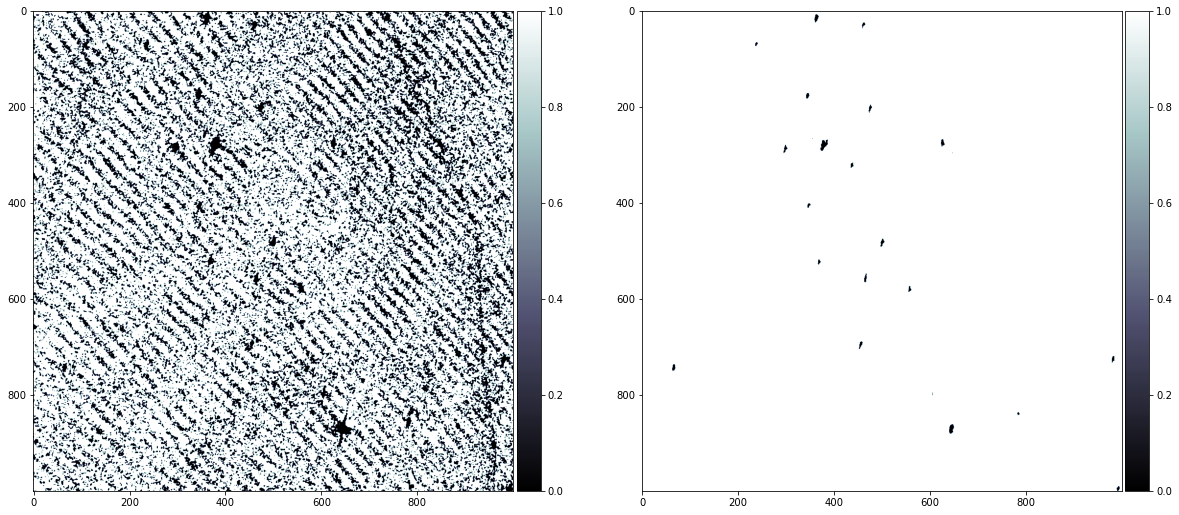

In [15]:
# plt.figure(figsize=(20,20))
# ax1 = plt.gca()

# # im1_1 = ax1.imshow(mask_im, alpha=0.5)
# im1 = ax1.imshow(density(vv[16400:16700,18300:18700]), cmap='bone')

# divider1 = make_axes_locatable(ax1)
# cax1 = divider1.append_axes("right", size="5%", pad=0.05)
# plt.colorbar(im1, cax=cax1)
# plt.show()

plt.figure(figsize=(20,20))
plt.subplot(1,2,1)

ax1 = plt.gca()
im1 = ax1.imshow(np.abs(vv), cmap='bone')
divider1 = make_axes_locatable(ax1)
cax1 = divider1.append_axes("right", size="5%", pad=0.05)

plt.colorbar(im1, cax=cax1)

plt.subplot(1,2,2)

ax2 = plt.gca()
im2 = ax2.imshow(np.abs(vh), cmap='bone')
divider2 = make_axes_locatable(ax2)
cax2 = divider2.append_axes("right", size="5%", pad=0.05)

plt.colorbar(im2, cax=cax2)

plt.show()



plt.figure(figsize=(20,20))
plt.subplot(1,2,1)

ax1 = plt.gca()
im1 = ax1.imshow(np.abs(vv)>20.0, cmap='bone')
divider1 = make_axes_locatable(ax1)
cax1 = divider1.append_axes("right", size="5%", pad=0.05)

plt.colorbar(im1, cax=cax1)

plt.subplot(1,2,2)

ax2 = plt.gca()
im2 = ax2.imshow(np.abs(vh)>20.0, cmap='bone')
divider2 = make_axes_locatable(ax2)
cax2 = divider2.append_axes("right", size="5%", pad=0.05)

plt.colorbar(im2, cax=cax2)

plt.show()

In [27]:
from scipy.signal import convolve2d

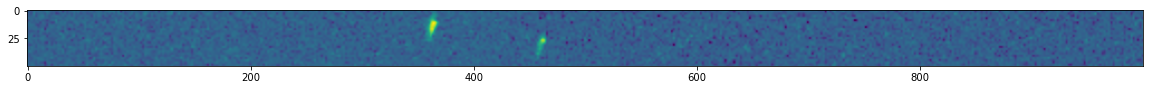

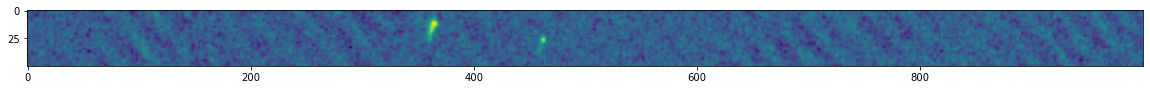

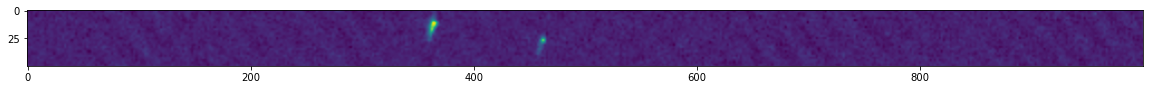

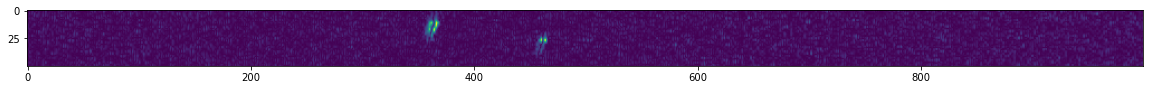

In [106]:
plt.figure(figsize=(20,4))
plt.imshow(vh[:50,:]-np.amin(vh[:50,:]))
# plt.axhline(12, color='r')
# plt.axvline(np.argmax(conv_out), color='cyan')
plt.show()

plt.figure(figsize=(20,4))
plt.imshow(vv[:50,:]-np.amin(vv[:50,:]))
# plt.axhline(12, color='r')
# plt.axvline(np.argmax(conv_out), color='cyan')
plt.show()

mult = (vv[:50,:]-np.amin(vv[:50,:])) * (vh[:50,:]-np.amin(vh[:50,:]))

plt.figure(figsize=(20,4))
plt.imshow(np.abs(mult))
# plt.colorbar()
plt.show()

plt.figure(figsize=(20,4))
plt.imshow(np.abs(np.diff(mult, n=1, axis=1)))
# plt.colorbar()
plt.show()

In [ ]:
mask = thre

In [87]:
# conv_out = convolve2d(vh[:50,:], vv[:50,:], 'same')
conv_out = np.convolve(vv[12,:]-np.amin(vv[12,:]), vh[12,:]-np.amin(vh[12,:]), mode='same')

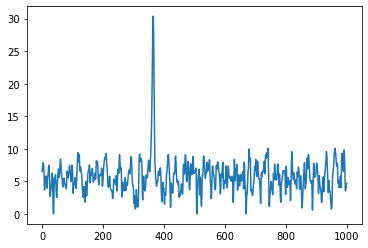

In [83]:
plt.plot(vv[12,:]-np.amin(vv[12,:]))

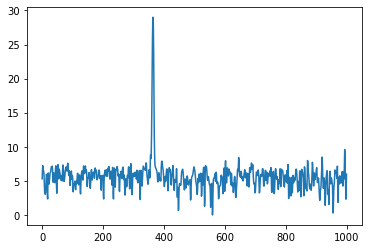

In [84]:
plt.plot(vh[12,:]-np.amin(vh[12,:]))

In [88]:
conv_out.shape

(1000,)

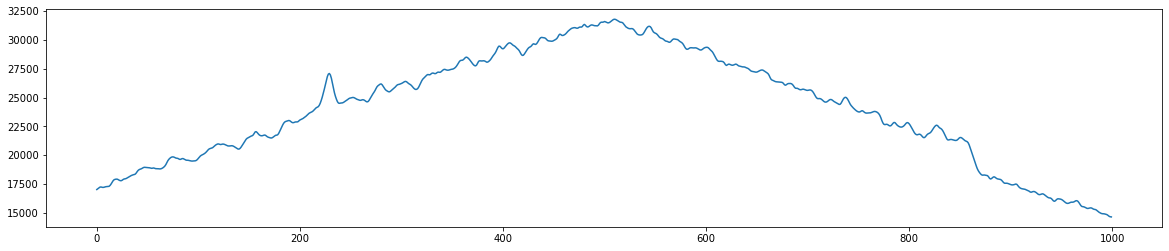

In [89]:
plt.figure(figsize=(20,4))
plt.plot(conv_out)

In [73]:
np.argmax(conv_out)

999

In [31]:
np.amin(np.abs(vh))

1.4345703

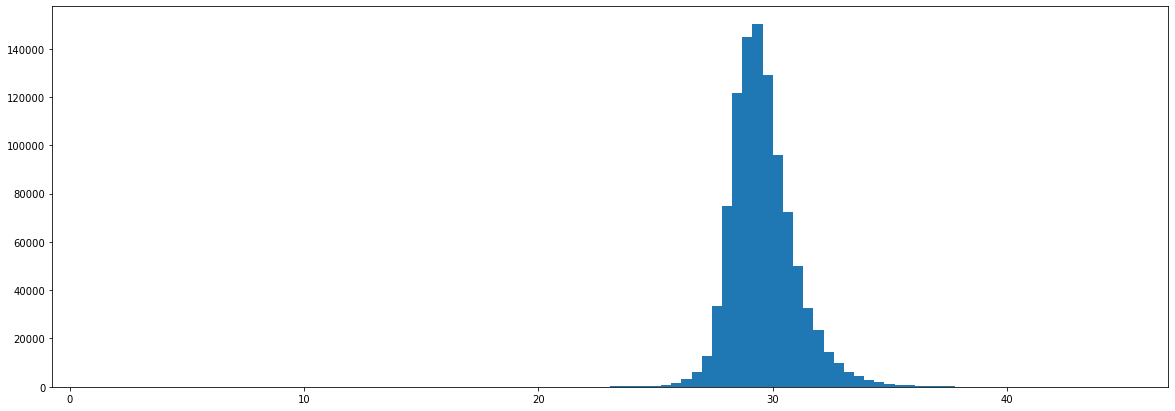

In [29]:
plt.figure(figsize=(20,7))
plt.hist(np.abs(vh.ravel()), bins=100);

In [107]:
from skimage.filters import *

In [108]:
vv.shape

(1000, 1000)

In [109]:
mult = (vv-np.amin(vv)) * (vh-np.amin(vh))

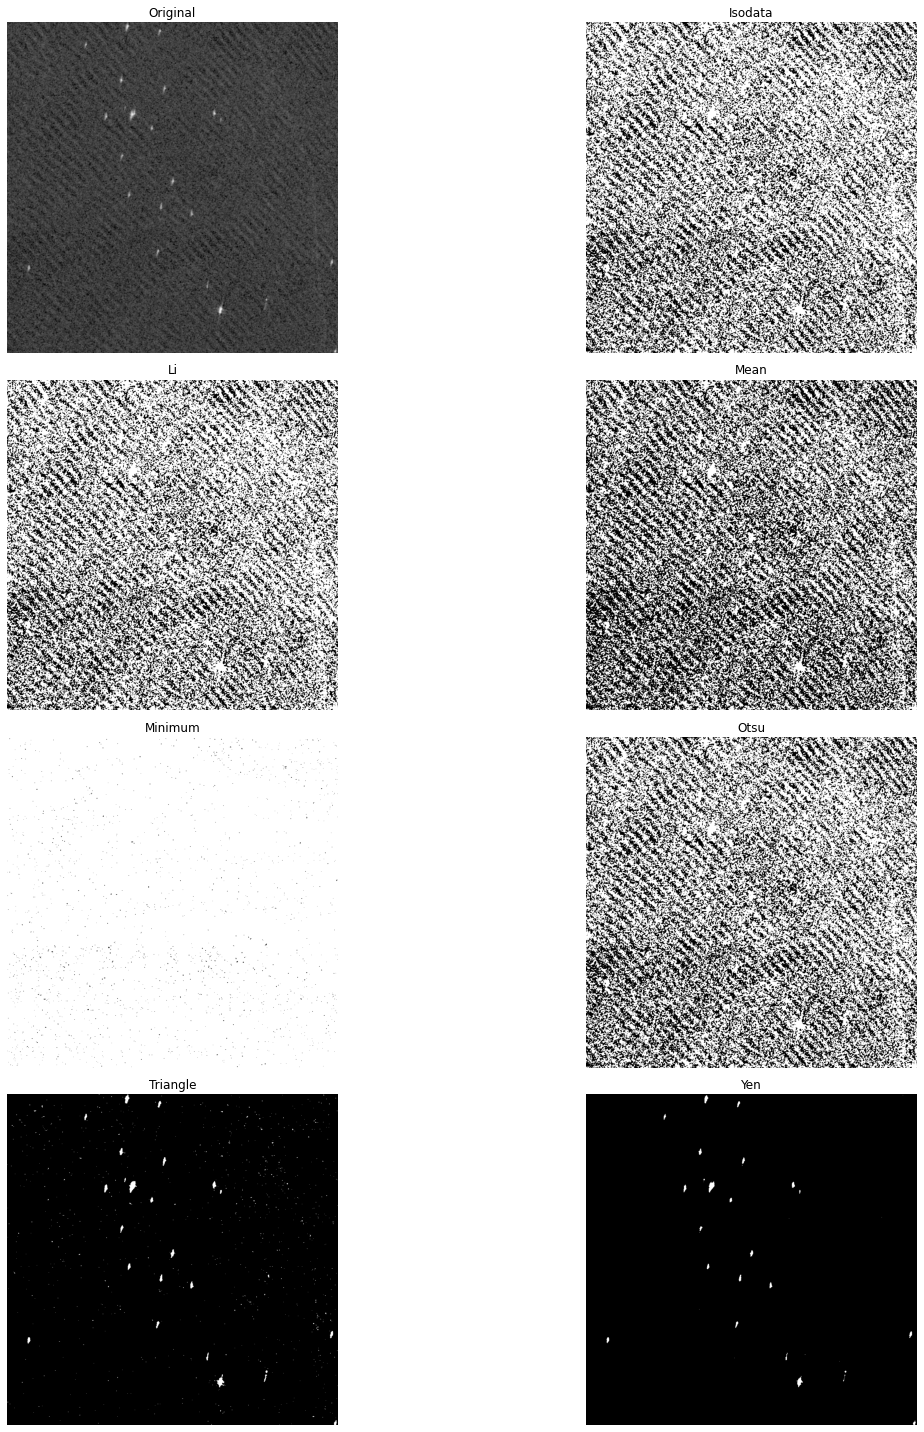

In [111]:
try_all_threshold(density(mult), figsize=(20,20), verbose=False);

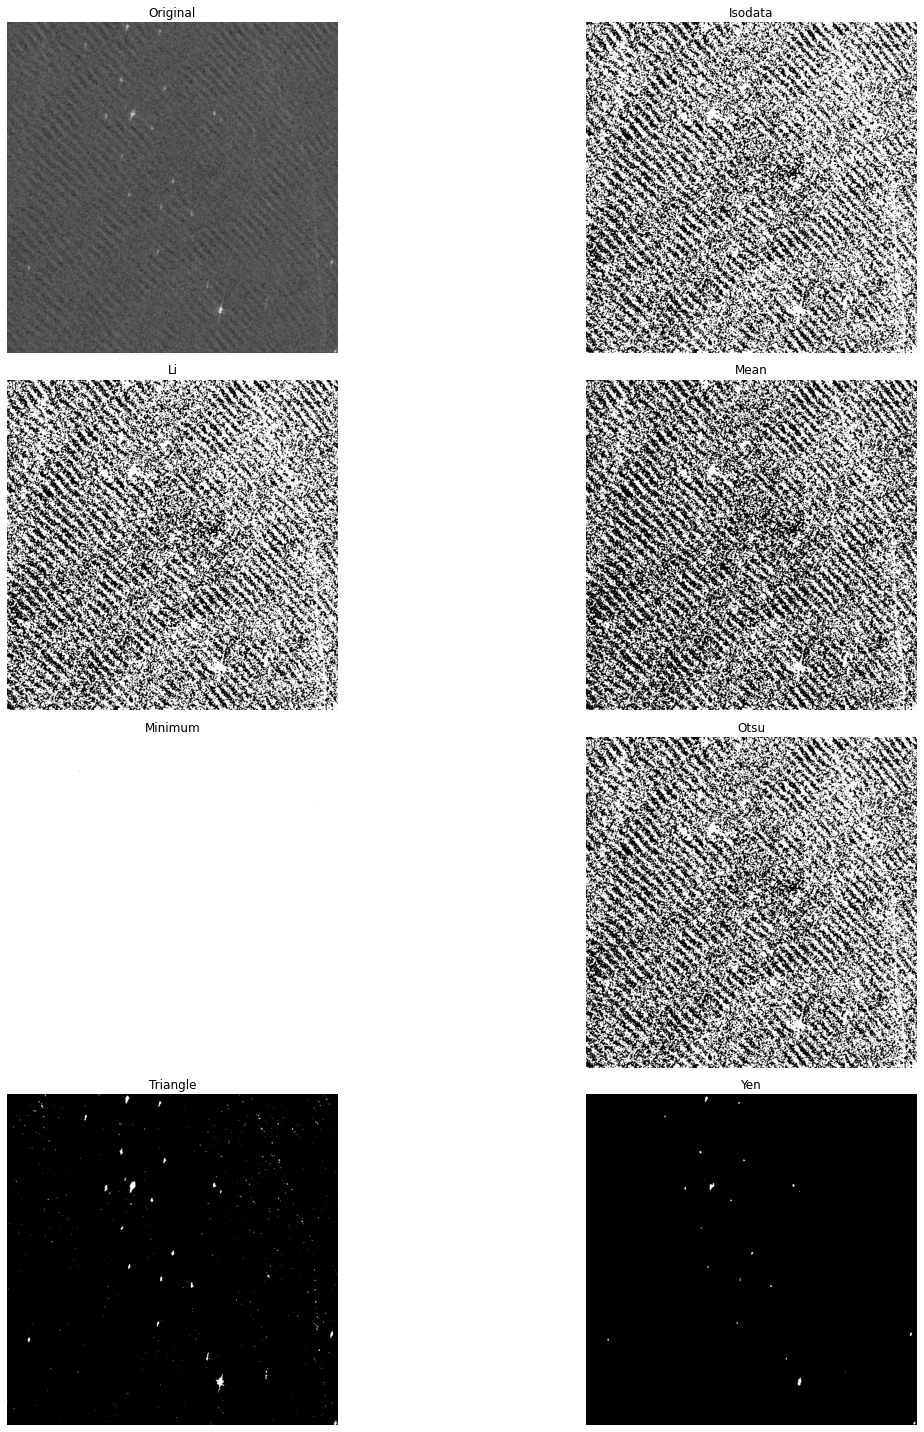

In [24]:
try_all_threshold((vv[7000:8000,13000:14000]), figsize=(20,20), verbose=False);

(array([   440.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,   4463., 245017.]),
 array([-32768.  , -29464.75, -26161.5 , -22858.25, -19555.  , -16251.75,
        -12948.5 ,  -9645.25,  -6342.  ,  -3038.75,    264.5 ],
       dtype=float32),
 <BarContainer object of 10 artists>)

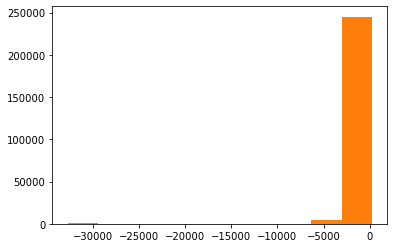

In [16]:
plt.hist(mask.ravel())
plt.hist(bath.ravel())

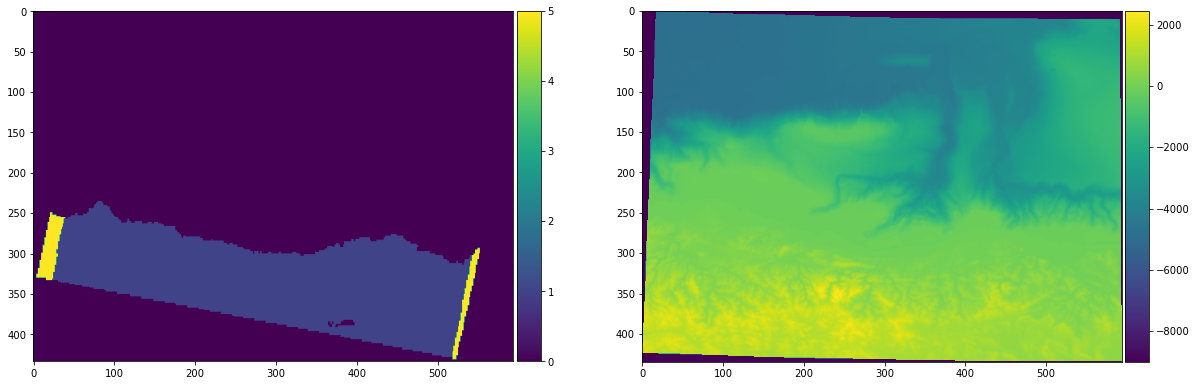

In [28]:
plt.figure(figsize=(20,20))
plt.subplot(1,2,1)


ax1 = plt.gca()
im1 = ax1.imshow(mask)
divider1 = make_axes_locatable(ax1)
cax1 = divider1.append_axes("right", size="5%", pad=0.05)

plt.colorbar(im1, cax=cax1)

plt.subplot(1,2,2)

ax2 = plt.gca()
im2 = ax2.imshow(bath, vmin=-9000)
divider2 = make_axes_locatable(ax2)
cax2 = divider2.append_axes("right", size="5%", pad=0.05)

plt.colorbar(im2, cax=cax2)

plt.show()